# Libraries

In [89]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta


# Reading Data files

### Bike rentals transactions (Kaggle dataset)

In [69]:
Bikes = pd.read_csv('Clean_FordGoBike_2017_2019.csv')
print(Bikes.shape)
Bikes.head()

,bike_id,end_station_id,end_station_latitude,end_station_longitude,start_station_id,start_station_latitude,start_station_longitude,start_time,low_income_trip,subscriber,gender,duration_min,user_age,year,month,week,day,weekday,hour
0,96,43,37.778768,-122.415929,74,37.776435,-122.426244,2017-12-31 16:57:39.654,0,0,1,1335.2,31,2017,12,52,31,6,16
1,88,96,37.766210,-122.426614,284,37.784872,-122.400876,2017-12-31 15:56:34.842,0,0,0,1313.3,53,2017,12,52,31,6,15
2,3167,247,37.867789,-122.265896,239,37.868813,-122.258764,2017-12-31 14:23:14.001,0,1,0,726.7,21,2017,12,52,31,6,14
3,3539,259,37.866249,-122.299371,259,37.866249,-122.299371,2017-12-31 23:49:28.422,0,0,0,75.1,27,2017,12,52,31,6,23
4,2311,24,37.789677,-122.390428,67,37.776639,-122.395526,2017-12-31 23:52:55.581,0,1,1,36.4,28,2017,12,52,31,6,23
5,3717,24,37.789677,-122.390428,67,37.776639,-122.395526,2017-12-31 23:52:55.937,0,1,1,36.2,28,2017,12,52,31,6,23
6,558,27,37.788059,-122.391865,14,37.795001,-122.399970,2017-12-31 23:53:38.943,0,1,0,25.7,38,2017,12,52,31,6,23
7,3646,27,37.788059,-122.391865,14,37.795001,-122.399970,2017-12-31 23:54:40.146,0,1,1,24.6,39,2017,12,52,31,6,23
8,3114,15,37.795392,-122.394203,78,37.773717,-122.411647,2017-12-31 23:52:49.497,0,1,0,25.5,30,2017,12,52,31,6,23
9,1473,123,37.760594,-122.414817,4,37.785881,-122.408915,2017-12-31 23:46:33.993,0,1,1,20.3,47,2017,12,52,31,6,23


### Filtering bike stations in San Francisco only

In [71]:
# Bikes = Bikes[Bikes["end_station_longitude"]<-122.36]

stations = list()
latitude = list()
longitude = list()
for i in Bikes.groupby(["end_station_id","end_station_latitude","end_station_longitude"]).groups.keys():
    stations.append(i[0])
    latitude.append(i[1])
    longitude.append(i[2])
print(len(latitude))
print(len(longitude))
print(len(stations))

401
401
401


### Showing stations on a map

In [73]:
import folium
# Make a data frame with dots to show on the map
data = pd.DataFrame([latitude,longitude,stations]).transpose()
data.columns = ["latitude","longitude","stations"]
data
 
# Make an empty map
from IPython.display import display
LDN_COORDINATES = (37.82, -122.31)
m = folium.Map(location=LDN_COORDINATES, zoom_start=11.4)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['latitude'], data.iloc[i]['longitude']], popup=data.iloc[i]['stations'], ).add_to(m)
    
display(m)

m.save('map.html')

### Creating variable for separating San Francisco area from Berkeley area

In [6]:
San_Francisco = pd.DataFrame(Bikes[Bikes["end_station_longitude"]<-122.36]["end_station_id"].unique())
San_Francisco.columns = ["Station"]
San_Francisco["City"] = 1
San_Francisco

,Station,City
0,43,1
1,96,1
2,24,1
3,27,1
4,15,1
...,...,...
167,352,1
168,376,1
169,411,1
170,410,1


### Weather history (Weather API)

In [41]:
weather = pd.read_csv('Weather_complete.csv', index_col=False)
weather.drop("Unnamed: 0", axis=1, inplace=True)
weather.columns = ["year","month","day","hour","tempC","weatherDesc","precipMM"]
weather.groupby("weatherDesc").agg({"precipMM": [min, max, np.median, np.mean], "tempC": [np.median, np.mean]})

precipMM                        tempC           
                          min  max median      mean median       mean
weatherDesc                                                          
Clear                     0.0  0.0    0.0  0.000000   14.0  14.073373
Cloudy                    0.0  0.0    0.0  0.000000   12.0  13.227592
Light rain                0.1  0.2    0.2  0.166667   12.0  12.333333
Light rain shower         0.0  0.1    0.1  0.066667   17.0  17.333333
Mist                      0.0  0.0    0.0  0.000000   11.0  11.500000
Moderate rain             0.4  2.7    1.2  1.386784   12.0  11.603524
Overcast                  0.0  0.0    0.0  0.000000   11.5  11.884615
Partly cloudy             0.0  0.0    0.0  0.000000   13.0  12.671706
Patchy light drizzle      0.0  0.1    0.0  0.035028   14.0  13.700565
Patchy rain possible      0.0  0.4    0.0  0.042034   14.0  13.647458
Sunny                     0.0  0.0    0.0  0.000000   18.0  18.208042

# Preparing dataset for analysis

### Bikes - initial and final stations

In [6]:
# Bikes rented by hour
end_station = pd.DataFrame(Bikes.groupby(['end_station_id','year', 'month', 'day', 'hour']) \
    .aggregate({'bike_id': 'count'})).reset_index()
end_station.rename(columns={'end_station_id':'Station', 'bike_id':'Bikes_in'},inplace=True)
end_station.head()

,Station,year,month,day,hour,Bikes_in
0,3,2017,6,29,14,1
1,3,2017,6,29,15,1
2,3,2017,6,29,16,4
3,3,2017,6,29,17,2
4,3,2017,6,29,19,4


In [69]:
# Bikes returned by hour
start_station = pd.DataFrame(Bikes.groupby(['start_station_id','year', 'month', 'day', 'hour']) \
    .aggregate({'bike_id': 'count'})).reset_index()
start_station.rename(columns={"start_station_id": "Station", "bike_id": "Bikes_out"},inplace=True)
start_station.head()

,Station,year,month,day,hour,Bikes_out
0,3,2017,6,29,14,2
1,3,2017,6,29,15,1
2,3,2017,6,29,16,2
3,3,2017,6,29,17,4
4,3,2017,6,29,18,6


### Stations / dates / hours list

In [68]:
# Creating list of dates and hours
dates = list()
date_new = datetime(2017, 6, 28)
for i in range(16128):
    dates.append(date_new)
    date_new = date_new + timedelta(hours=1)
dates = pd.DataFrame(dates, columns=["Dates"])
# Collecting stations codes on a list
stations = Bikes["end_station_id"].unique()
stations = stations.tolist()
stations = pd.DataFrame(stations, columns=["Station"])
stations["key"] = 0
dates["key"] = 0
# Merging stations and hours-days
teste = stations.merge(dates, how='left', on="key")
teste.drop("key",axis=1,inplace=True)
teste.head()

,Station,Dates
0,43,2017-06-28 00:00:00
1,43,2017-06-28 01:00:00
2,43,2017-06-28 02:00:00
3,43,2017-06-28 03:00:00
4,43,2017-06-28 04:00:00


### Creating Rentals per station file (1)

In [9]:
# Separating year, month, day and hour in different columns
teste["year"] =teste["Dates"].dt.year
teste["month"]=teste["Dates"].dt.month
teste["day"]  =teste["Dates"].dt.day
teste["hour"] =teste["Dates"].dt.hour
teste["weekday"] =teste["Dates"].dt.weekday
# teste.drop("Dates", axis=1, inplace=True)
# Merging stations-date-hour list to bike rentals/returns dataset
teste = teste.merge(end_station, how='left', on=['Station','year','month','day','hour'])
teste = teste.merge(start_station, how='left', on=['Station','year','month','day','hour'])
# Selecting only full month history
teste = teste[((teste["year"]==2017) & (teste["month"]>=7)) |
                     (teste["year"]==2018) |
                     (teste["year"]==2019)]
# Filling the gaps with 0s
teste = teste.fillna(0)
teste.tail()

,Station,Dates,year,month,day,hour,weekday,Bikes_in,Bikes_out
5999611,391,2019-04-30 19:00:00,2019,4,30,19,1,0.0,0.0
5999612,391,2019-04-30 20:00:00,2019,4,30,20,1,0.0,0.0
5999613,391,2019-04-30 21:00:00,2019,4,30,21,1,0.0,0.0
5999614,391,2019-04-30 22:00:00,2019,4,30,22,1,0.0,0.0
5999615,391,2019-04-30 23:00:00,2019,4,30,23,1,0.0,0.0


### Variables creation

In [25]:
# Holidays
teste["holidays"] = (
((teste["year"]==2017) & (teste["month"]==7)  & (teste["day"]==4 )) |
((teste["year"]==2017) & (teste["month"]==9 ) & (teste["day"]==4 )) |
((teste["year"]==2017) & (teste["month"]==9 ) & (teste["day"]==9 )) |
((teste["year"]==2017) & (teste["month"]==9 ) & (teste["day"]==22)) |
((teste["year"]==2017) & (teste["month"]==11) & (teste["day"]==10)) |
((teste["year"]==2017) & (teste["month"]==11) & (teste["day"]==23)) |
((teste["year"]==2017) & (teste["month"]==11) & (teste["day"]==24)) |
((teste["year"]==2017) & (teste["month"]==12) & (teste["day"]==25)) |
((teste["year"]==2018) & (teste["month"]==1 ) & (teste["day"]==1 )) |
((teste["year"]==2018) & (teste["month"]==1 ) & (teste["day"]==15)) |
((teste["year"]==2018) & (teste["month"]==2 ) & (teste["day"]==19)) |
((teste["year"]==2018) & (teste["month"]==3 ) & (teste["day"]==31)) |
((teste["year"]==2018) & (teste["month"]==5 ) & (teste["day"]==28)) |
((teste["year"]==2018) & (teste["month"]==7 ) & (teste["day"]==4 )) |
((teste["year"]==2018) & (teste["month"]==9 ) & (teste["day"]==3 )) |
((teste["year"]==2018) & (teste["month"]==9 ) & (teste["day"]==9 )) |
((teste["year"]==2018) & (teste["month"]==9 ) & (teste["day"]==28)) |
((teste["year"]==2018) & (teste["month"]==11) & (teste["day"]==12)) |
((teste["year"]==2018) & (teste["month"]==11) & (teste["day"]==22)) |
((teste["year"]==2018) & (teste["month"]==11) & (teste["day"]==23)) |
((teste["year"]==2018) & (teste["month"]==12) & (teste["day"]==5 )) |
((teste["year"]==2018) & (teste["month"]==12) & (teste["day"]==25)) |
((teste["year"]==2019) & (teste["month"]==1 ) & (teste["day"]==1 )) |
((teste["year"]==2019) & (teste["month"]==1 ) & (teste["day"]==21)) |
((teste["year"]==2019) & (teste["month"]==2 ) & (teste["day"]==18)) |
((teste["year"]==2019) & (teste["month"]==4 ) & (teste["day"]==1 ))) *1

# Seasons
teste.loc[ (teste["Dates"]< '2017-09-22'),"season"] = "Summer"
teste.loc[((teste["Dates"]>='2017-09-22') & (teste["Dates"]<'2017-12-21')),"season"] = "Fall"
teste.loc[((teste["Dates"]>='2017-12-21') & (teste["Dates"]<'2018-03-20')),"season"] = "Winter"
teste.loc[((teste["Dates"]>='2018-03-20') & (teste["Dates"]<'2018-06-21')),"season"] = "Spring"
teste.loc[((teste["Dates"]>='2018-06-21') & (teste["Dates"]<'2018-09-22')),"season"] = "Summer"
teste.loc[((teste["Dates"]>='2018-09-22') & (teste["Dates"]<'2018-12-21')),"season"] = "Fall"
teste.loc[((teste["Dates"]>='2018-12-21') & (teste["Dates"]<'2019-03-20')),"season"] = "Winter"
teste.loc[ (teste["Dates"]>='2019-03-20'),"season"] = "Spring"

# Working day
teste["workingday"] = ((teste["holidays"]==0) & (teste["weekday"]<5))*1

# Bikes flow - Difference between bikes in and bikes out by station, by hour
teste["Flow"] = teste["Bikes_in"] - teste["Bikes_out"]

teste.head()

,Station,Dates,year,month,day,hour,weekday,Bikes_in,Bikes_out,holidays,season,workingday,Flow
72,43,2017-07-01 00:00:00,2017,7,1,0,5,0.0,0.0,0,Summer,0,0.0
73,43,2017-07-01 01:00:00,2017,7,1,1,5,0.0,0.0,0,Summer,0,0.0
74,43,2017-07-01 02:00:00,2017,7,1,2,5,0.0,0.0,0,Summer,0,0.0
75,43,2017-07-01 03:00:00,2017,7,1,3,5,0.0,0.0,0,Summer,0,0.0
76,43,2017-07-01 04:00:00,2017,7,1,4,5,0.0,0.0,0,Summer,0,0.0


In [26]:
mergesets = pd.merge(teste,weather,how='left',on=["year","month","day","hour"])
mergesets.to_csv(r'C:\Users\Victor Leo\Desktop\WeCloud - Python for Data Science\Project 2\mergesets.csv', index=False)

### Creating aggregated file - Total numbers for San Francisco (2)

In [30]:
teste2 = teste.groupby(['year','month','day','hour','holidays','weekday','season','workingday']) \
                              .aggregate({'Bikes_in': 'sum',
                                          'Bikes_out': 'sum'}).reset_index()
teste2["Flow"] = teste2["Bikes_in"] - teste2["Bikes_out"]
teste2.head()

,year,month,day,hour,holidays,weekday,season,workingday,Bikes_in,Bikes_out,Flow
0,2017,7,1,0,0,5,Summer,0,1.0,1.0,0.0
1,2017,7,1,1,0,5,Summer,0,1.0,1.0,0.0
2,2017,7,1,2,0,5,Summer,0,2.0,2.0,0.0
3,2017,7,1,3,0,5,Summer,0,0.0,0.0,0.0
4,2017,7,1,4,0,5,Summer,0,1.0,1.0,0.0


In [31]:
mergesets2 = pd.merge(teste2,weather,how='left',on=["year","month","day","hour"])
mergesets2.to_csv(r'C:\Users\Victor Leo\Desktop\WeCloud - Python for Data Science\Project 2\mergesets2.csv', index=False)

# Data Preparation

### Reading dataset: 1) Rentals per station 2) Total rentals 

In [42]:
# Import mergesets OR mergesets2
mergesets = pd.read_csv('mergesets2.csv', index_col=False)
print(mergesets.columns)
mergesets.shape

Index(['year', 'month', 'day', 'hour', 'holidays', 'weekday', 'season',
       'workingday', 'Bikes_in', 'Bikes_out', 'Flow', 'tempC', 'weatherDesc',
       'precipMM'],
      dtype='object')


(16056, 14)

### Setting the city: 1 = San Francisco, 0 = Berkeley (for stations only)

In [ ]:
# mergesets = pd.merge(mergesets,San_Francisco,how='left',on=["Station"])
# mergesets = mergesets.fillna(0)
# mergesets["City"].value_counts()

### Creating dummies and defining X and Y for the model

# Exploratory analysis

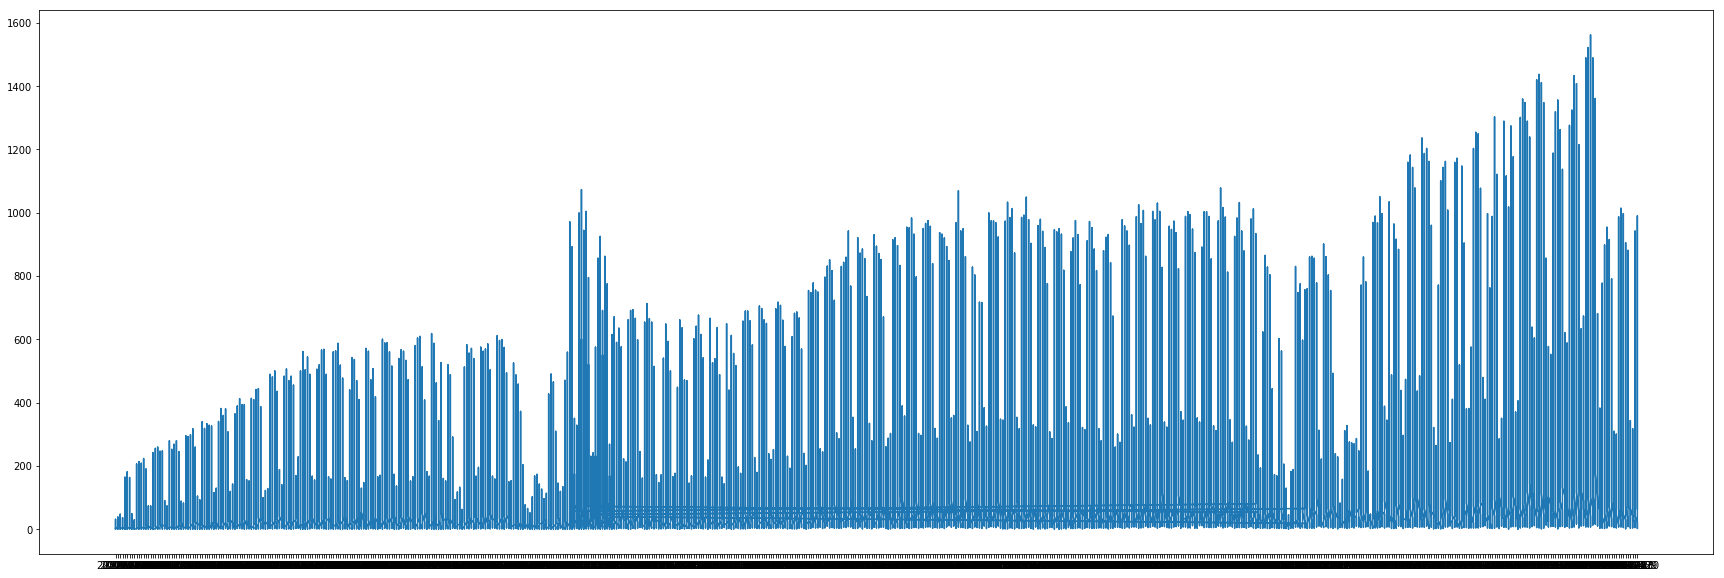

In [202]:
fig, ax1 = plt.subplots(figsize=(30,10))
mergesets["dates"] = mergesets["year"].astype(str)+mergesets["month"].astype(str)+mergesets["day"].astype(str)
plt.plot(mergesets["dates"],mergesets["Bikes_out"])

[Text(0.5, 1.0, 'Boxplot for seasons')]

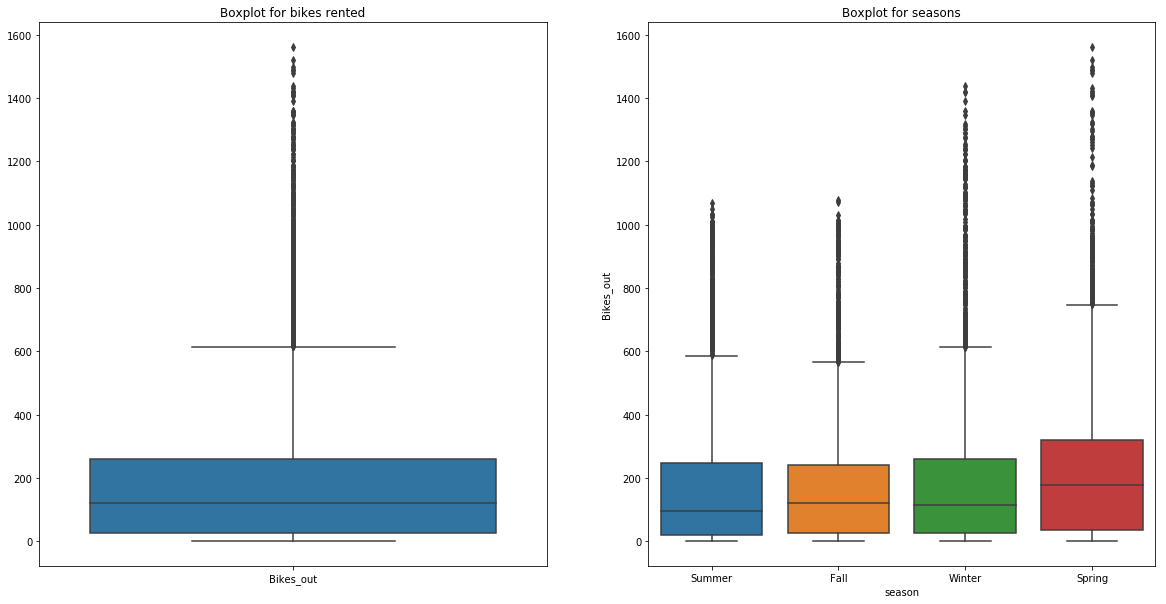

In [80]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))
sn.boxplot(data=mergesets[['Bikes_out']], ax=ax1)
ax1.set(title="Boxplot for bikes rented")
sn.boxplot(x=mergesets['season'],y=mergesets['Bikes_out'], ax=ax2)
ax2.set(title="Boxplot for seasons")

In [46]:
# mergesets_st = pd.read_csv('mergesets.csv', index_col=False)
# mergesets_st.columns
# # mergesets_st.shape
# San_Francisco = pd.DataFrame(Bikes[Bikes["end_station_longitude"]<-122.36]["end_station_id"].unique())
# San_Francisco.columns = ["Station"]
# San_Francisco["City"] = 1
# mergesets_st = pd.merge(mergesets_st,San_Francisco,how='left',on=["Station"])
# mergesets_st = mergesets_st.fillna(0)
mergesets_st.groupby(["City","weekday"]).Bikes_out.describe()

City  weekday
0.0   0          0.0
      1          0.0
      2          0.0
      3          0.0
      4          0.0
      5          0.0
      6          0.0
1.0   0          0.0
      1          0.0
      2          0.0
      3          0.0
      4          0.0
      5          0.0
      6          0.0
Name: Bikes_out, dtype: float64

[Text(0.5, 1.0, 'Use of the system during weekdays and weekends')]

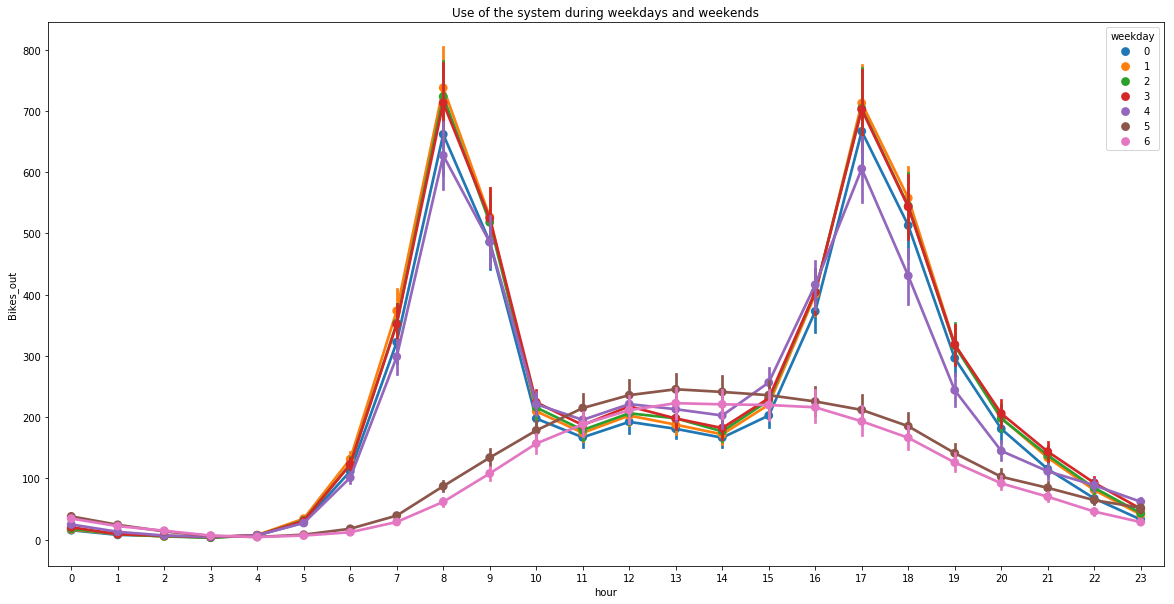

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
sn.pointplot(data=mergesets[['hour',
                       'Bikes_out',
                       'weekday']],
            x='hour', y='Bikes_out',
            hue='weekday', ax=ax)
ax.set(title="Use of the system during weekdays and weekends")

[Text(0.5, 1.0, 'Use of the system during weekdays and weekends')]

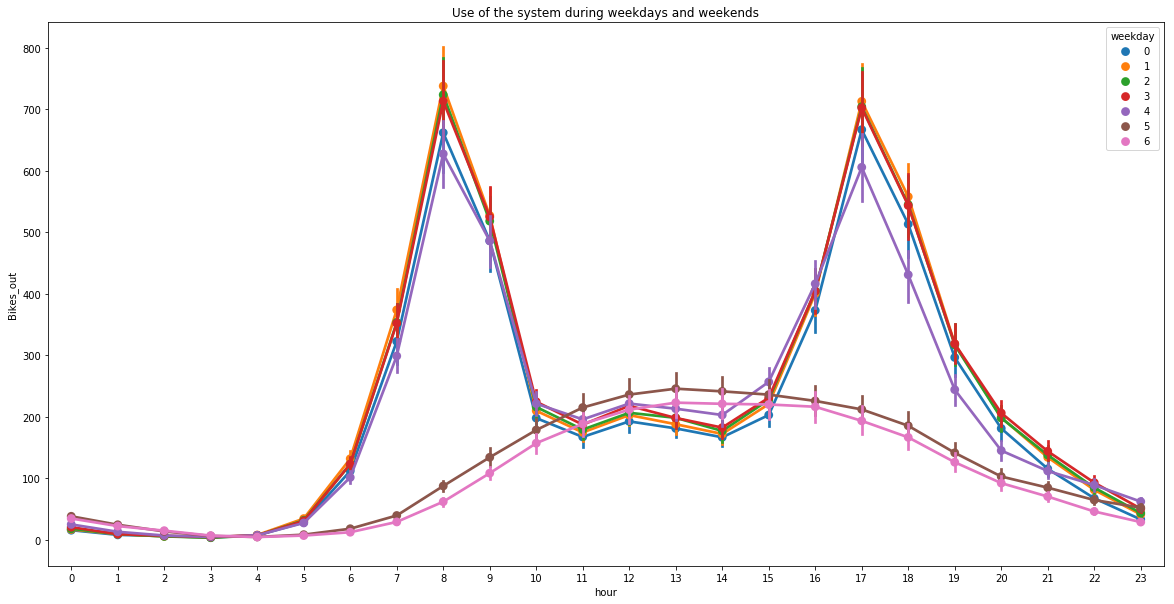

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
sn.pointplot(data=mergesets[['hour',
                       'Bikes_out',
                       'weekday']],
            x='hour', y='Bikes_out',
            hue='weekday', ax=ax)
ax.set(title="Use of the system during weekdays and weekends")

[Text(0.5, 1.0, 'Use of the system during weekdays and weekends')]

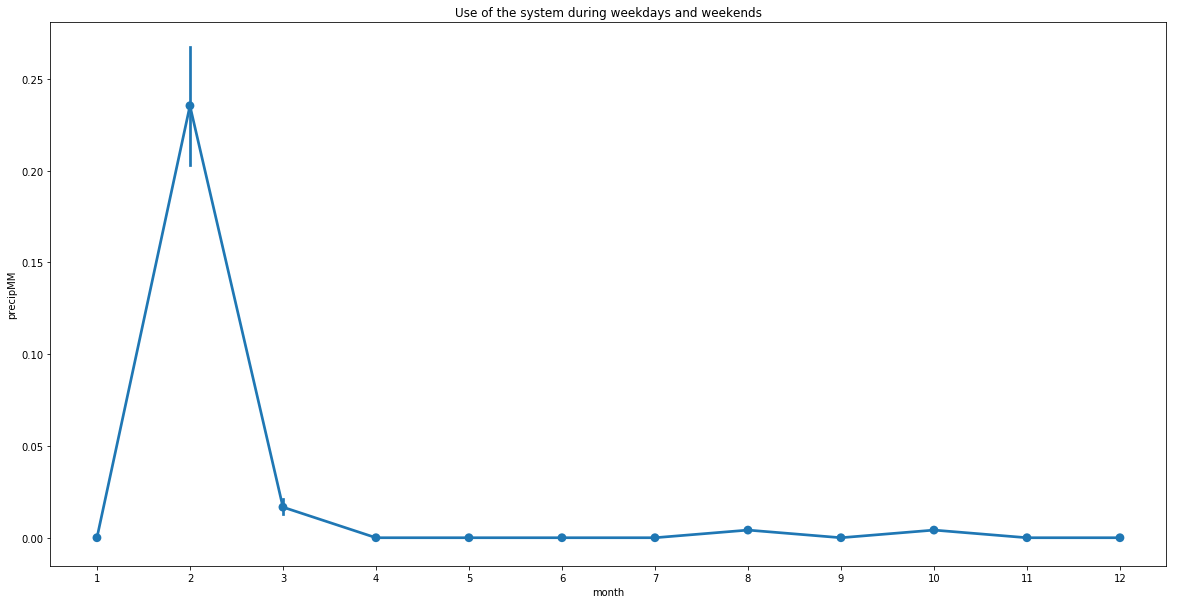

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
sn.pointplot(data=mergesets[['month',
                       'precipMM']],
            x='month', y='precipMM', ax=ax)
ax.set(title="Use of the system during weekdays and weekends")

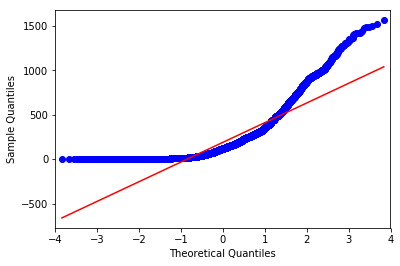

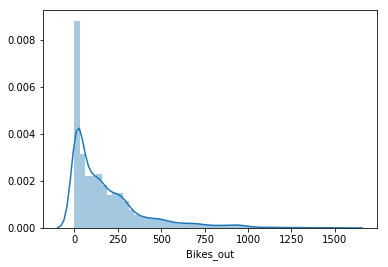

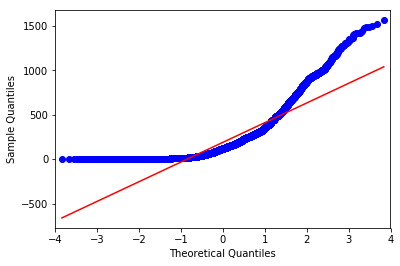

In [181]:
# Histogram - Bikes Out
from statsmodels.graphics.gofplots import qqplot

sn.distplot(mergesets['Bikes_out'])
qqplot(mergesets['Bikes_out'], line='s')

# PLUS: charts per weekday; stations; city; hour; tempCC;
#       graphs for testing regression assumptions (normality, homoscedasticity, etc)

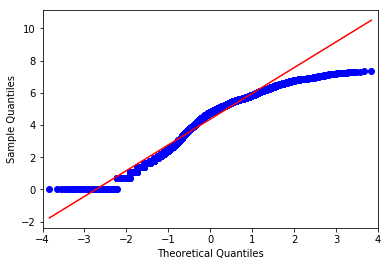

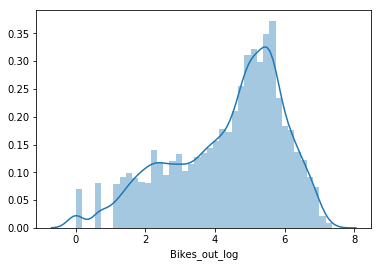

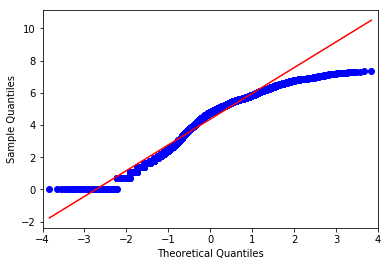

In [178]:
sn.distplot(mergesets['Bikes_out_log'])
qqplot(mergesets['Bikes_out_log'], line='s')

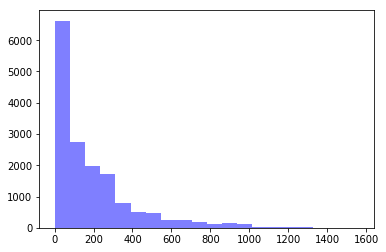

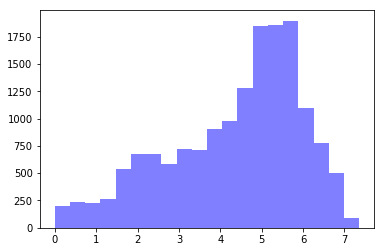

In [152]:
# Histogram - Original data
n, bins, patches = plt.hist(mergesets['Bikes_out'], 20, facecolor='blue', alpha=0.5)
plt.show()
# Histogram - Transformed data
n, bins, patches = plt.hist(mergesets['Bikes_out_log'], 20, facecolor='blue', alpha=0.5)
plt.show()

[Text(0.5, 1.0, 'Monthly distribution')]

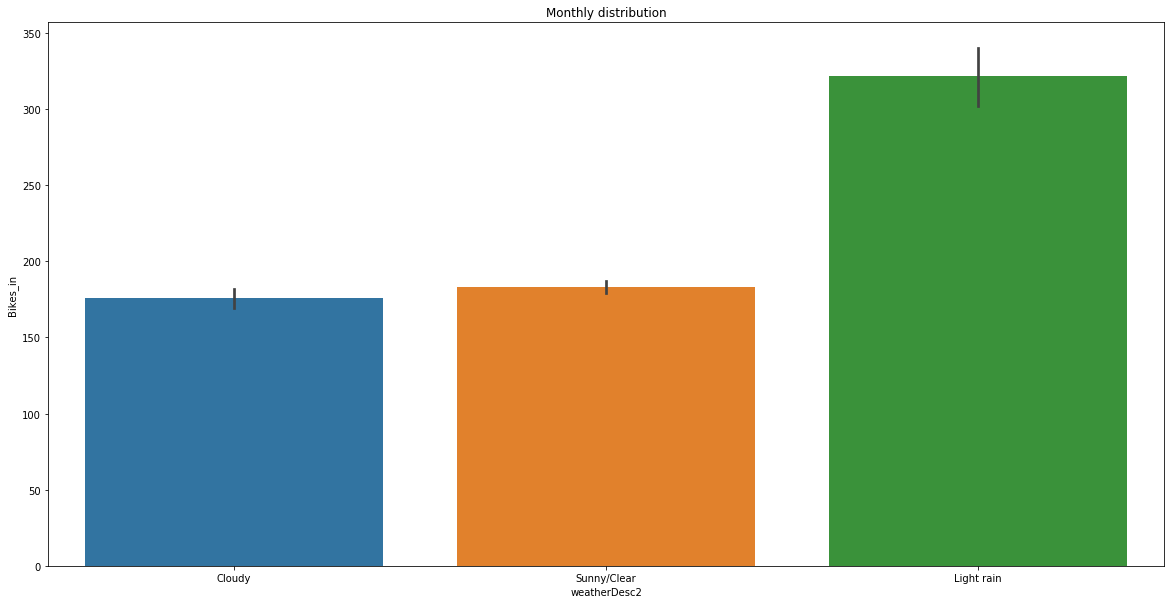

In [57]:
mergesets.loc[((mergesets["weatherDesc"]=='Sunny') | (mergesets["weatherDesc"]=='Clear')),"weatherDesc2"] = "Sunny/Clear"
mergesets.loc[((mergesets["weatherDesc"]=='Partly cloudy') | (mergesets["weatherDesc"]=='Cloudy') | (mergesets["weatherDesc"]=='Overcast') | (mergesets["weatherDesc"]=='Mist')),"weatherDesc2"] = "Cloudy"
mergesets.loc[((mergesets["weatherDesc"]=='Patchy rain possible') | (mergesets["weatherDesc"]=='Light rain shower') | (mergesets["weatherDesc"]=='Patchy light drizzle') | (mergesets["weatherDesc"]=='Light rain shower') | (mergesets["weatherDesc"]=='Light rain')),"weatherDesc2"] = "Light rain"
mergesets.loc[(mergesets["weatherDesc"]=='Moderate rain'),"weatherDesc2"] = "Light rain"
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=mergesets[["weatherDesc2", "Bikes_in"]], x="weatherDesc2", y='Bikes_in')
ax.set(title="Monthly distribution")

[Text(0.5, 1.0, 'Use of the system during on different weather conditions')]

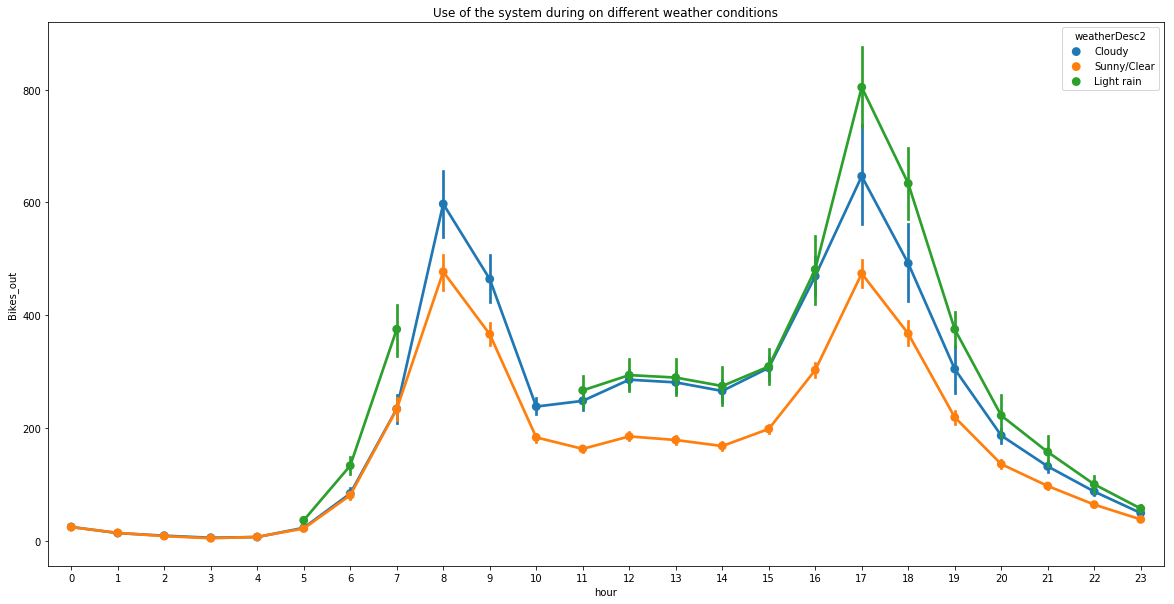

In [203]:
fig, ax = plt.subplots(figsize=(20,10))
sn.pointplot(data=mergesets[['hour',
                       'Bikes_out',
                       'weatherDesc2']],
            x='hour', y='Bikes_out',
            hue='weatherDesc2', ax=ax)
ax.set(title="Use of the system during on different weather conditions")

[Text(0.5, 1.0, 'Monthly distribution')]

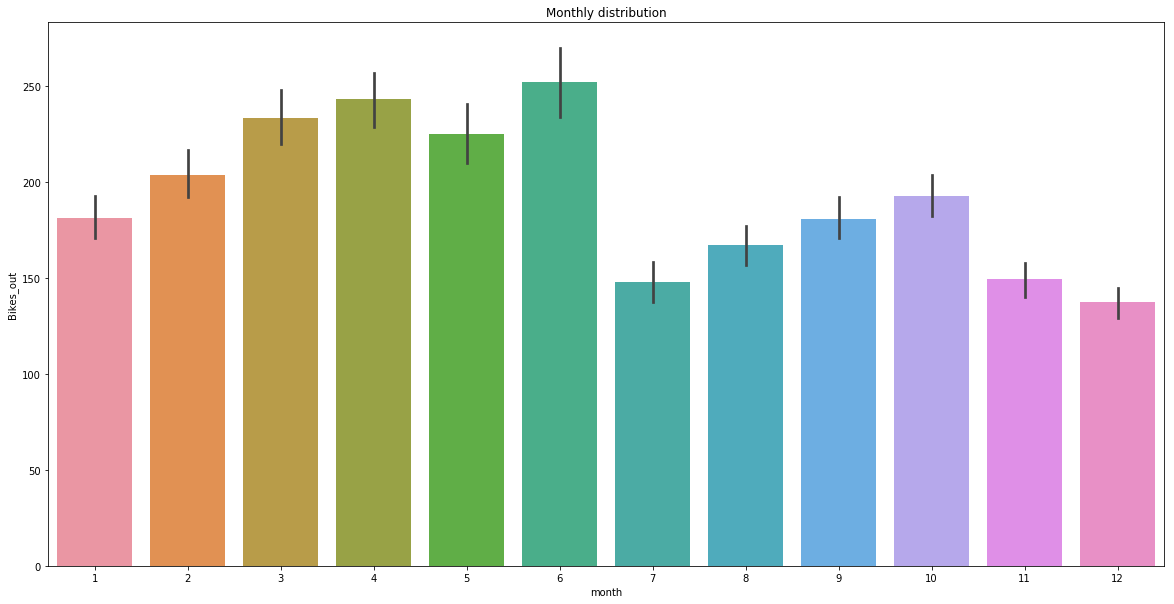

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=mergesets[["month", "Bikes_out"]], x="month", y='Bikes_out')
ax.set(title="Monthly distribution")

[Text(0.5, 1.0, 'Weekday distribution')]

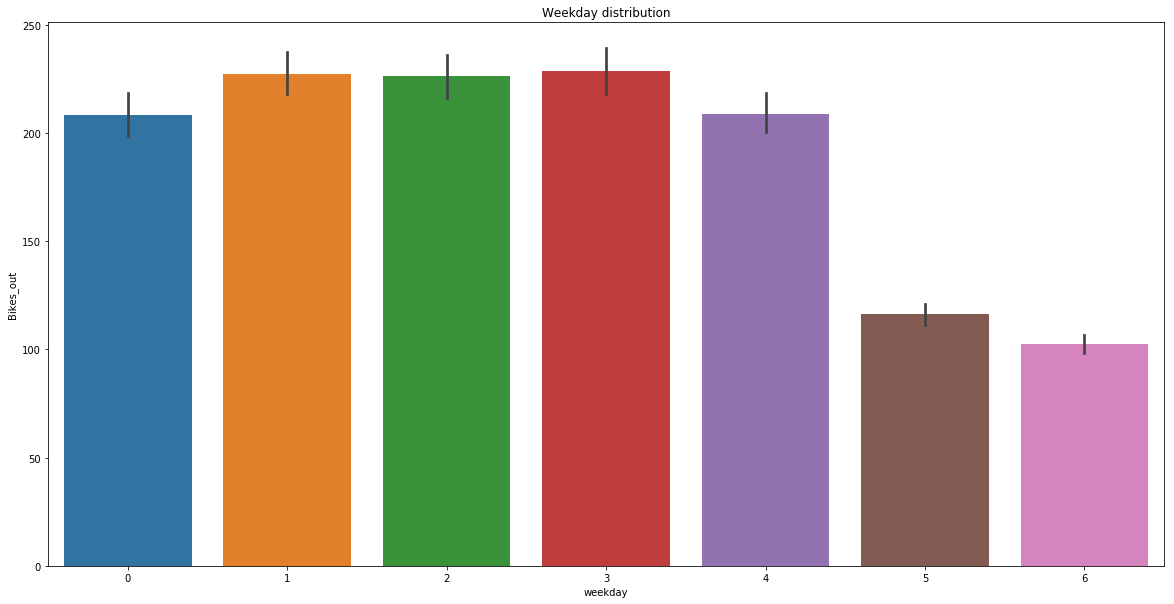

In [75]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=mergesets[["weekday", "Bikes_out"]], x="weekday", y='Bikes_out')
ax.set(title="Weekday distribution")

[Text(0.5, 1.0, 'Monthly distribution')]

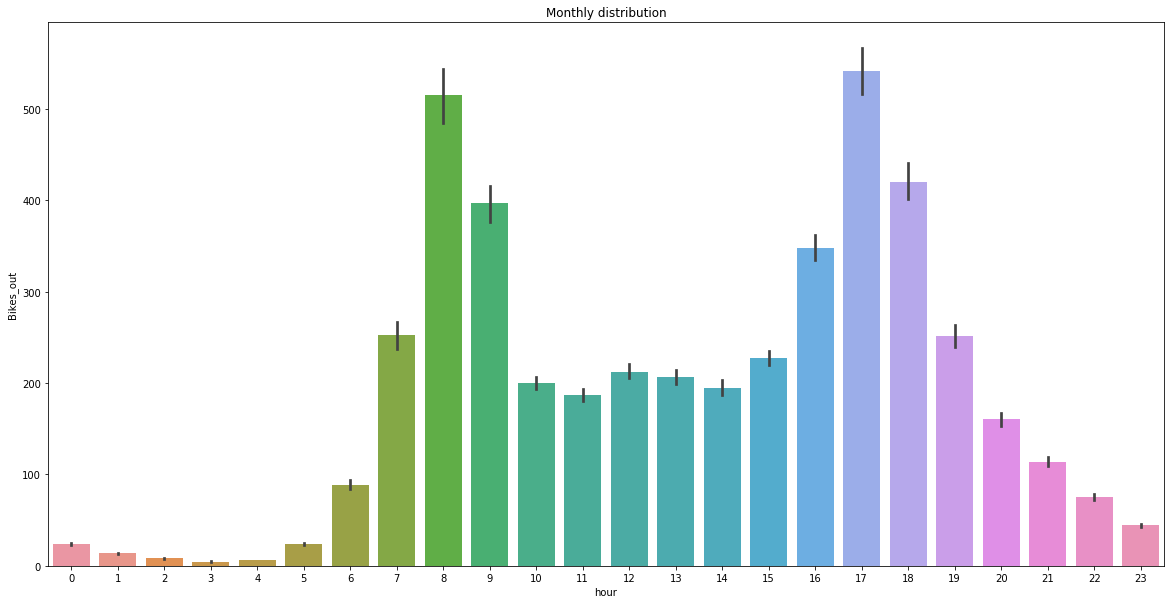

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=mergesets[["hour", "Bikes_out"]], x="hour", y='Bikes_out')
ax.set(title="Monthly distribution")

[Text(0.5, 1.0, 'Monthly distribution')]

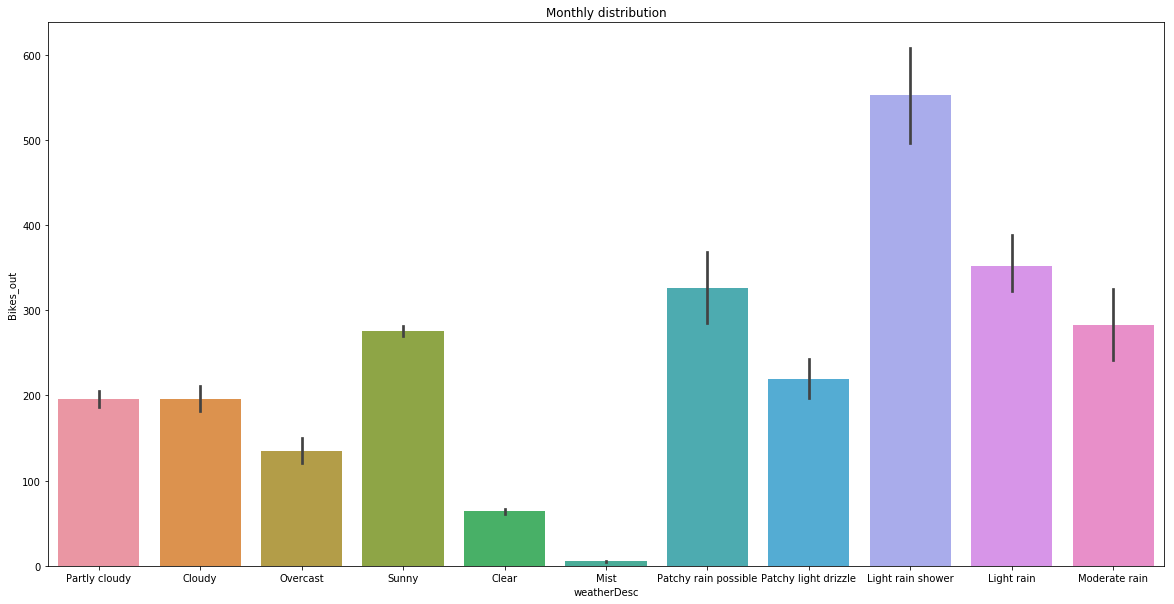

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=mergesets[mergesets["workingday"]==0][["weatherDesc", "Bikes_out"]], x="weatherDesc", y='Bikes_out')
ax.set(title="Monthly distribution")

[Text(0.5, 1.0, 'Hourly distribution')]

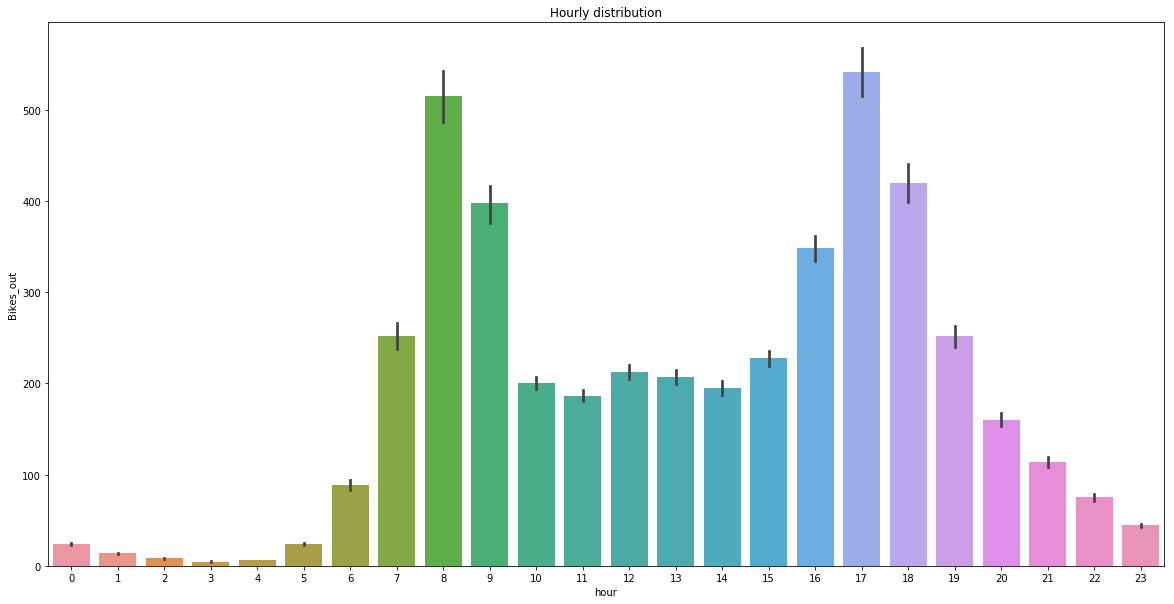

In [120]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=mergesets[["hour", "Bikes_out"]], x="hour", y='Bikes_out')
ax.set(title="Hourly distribution")

C:\Users\Victor Leo\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\Victor Leo\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\Victor Leo\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\Victor Leo\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left==right results
in singu

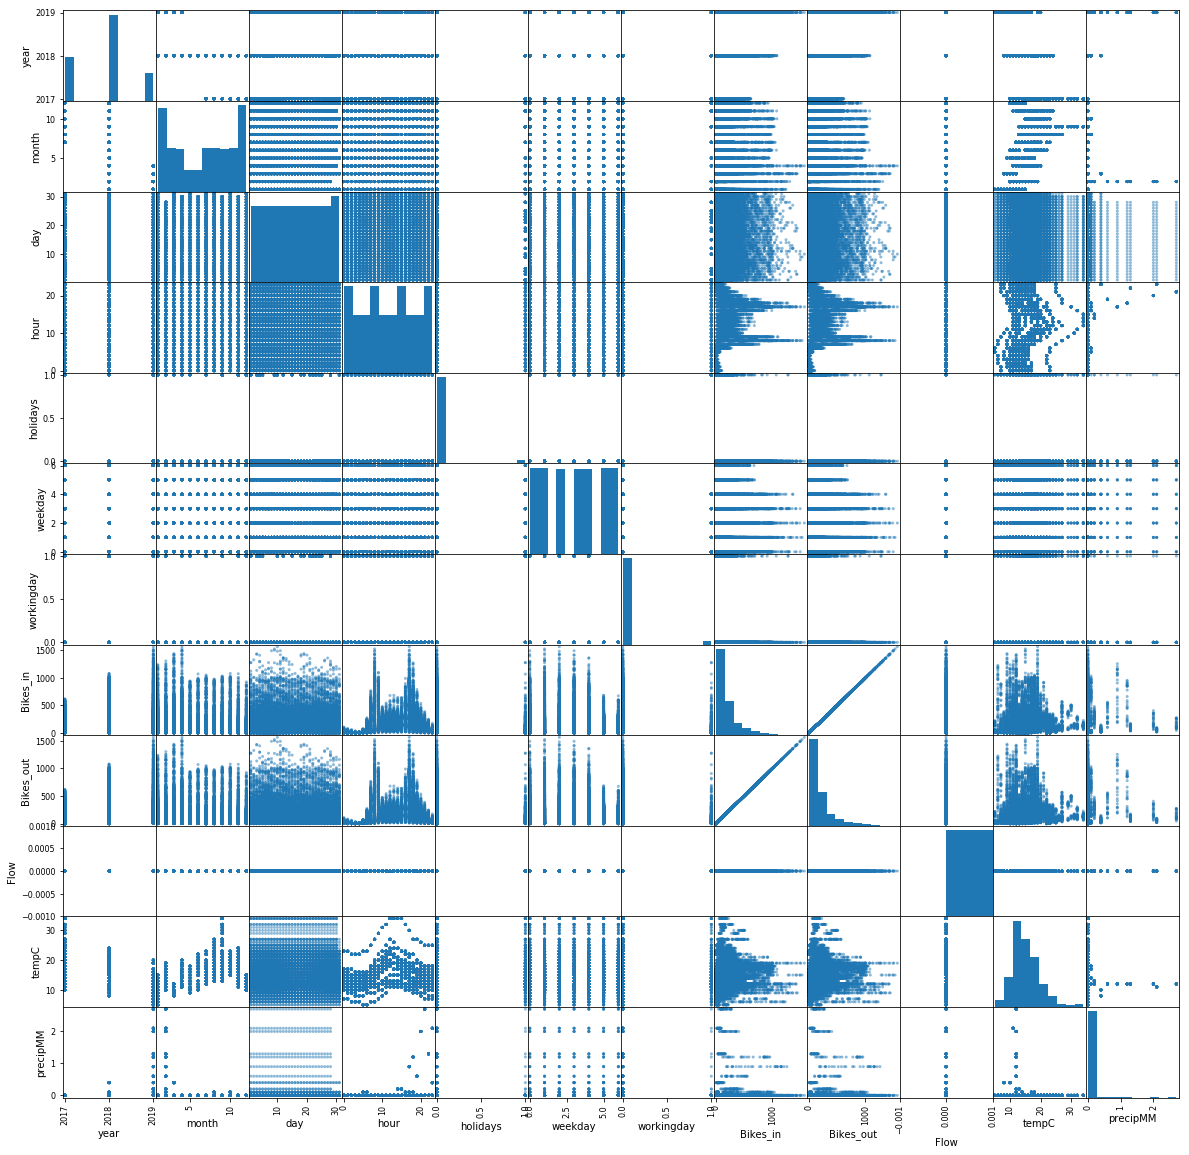

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.scatter_matrix(mergesets, figsize=(20, 20));

# Modelling

In [92]:
mergesets.columns

Index(['year', 'month', 'day', 'hour', 'holidays', 'weekday', 'season',
       'workingday', 'Bikes_in', 'Bikes_out', 'Flow', 'tempC', 'weatherDesc',
       'precipMM', 'weatherDesc2', 'Bikes_out_log'],
      dtype='object')

In [107]:
# Factors
X = pd.concat([mergesets[['tempC','precipMM','holidays','year']],
#                pd.get_dummies(mergesets['City'], drop_first=True, prefix='city'),
               pd.get_dummies(mergesets['month'], drop_first=True, prefix='month'),
               pd.get_dummies(mergesets['day'], drop_first=True, prefix='day'),
               pd.get_dummies(mergesets['weekday'], drop_first=True, prefix='weekday'),
               pd.get_dummies(mergesets['hour'], drop_first=True, prefix='hour'),
               pd.get_dummies(mergesets['season'], drop_first=True, prefix='season'),
               pd.get_dummies(mergesets['weatherDesc'], drop_first=True)], axis=1)
# Target
######## Transforming Bikes_out - Testing model only. Must analyze it deeply on descriptives
mergesets['Bikes_out_log'] = np.log(mergesets['Bikes_out'] + 1)
y = mergesets["Bikes_out_log"]
# Random samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234)
# Files sizes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X.columns)

(8028, 87)
(8028, 87)
(8028,)
(8028,)
Index(['tempC', 'precipMM', 'holidays', 'year', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12',
       'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19',
       'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26',
       'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'season_Spring',
       'season_Summer', 'season_Winter', 'Cloudy', 'Light rain',
       'Light rai

### Linear Regression

In [184]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [185]:
model.score(X_train, y_train)

0.8706917472440002

In [186]:
model.score(X_test, y_test)

# PLUS: performance metrics

0.8667246130160017

In [187]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
R2_ = r2_score(y_test, y_pred)
MSE_ = mean_squared_error(y_test, y_pred)
print(R2_, MSE_)

0.8667246130160017 0.34176465455965327


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


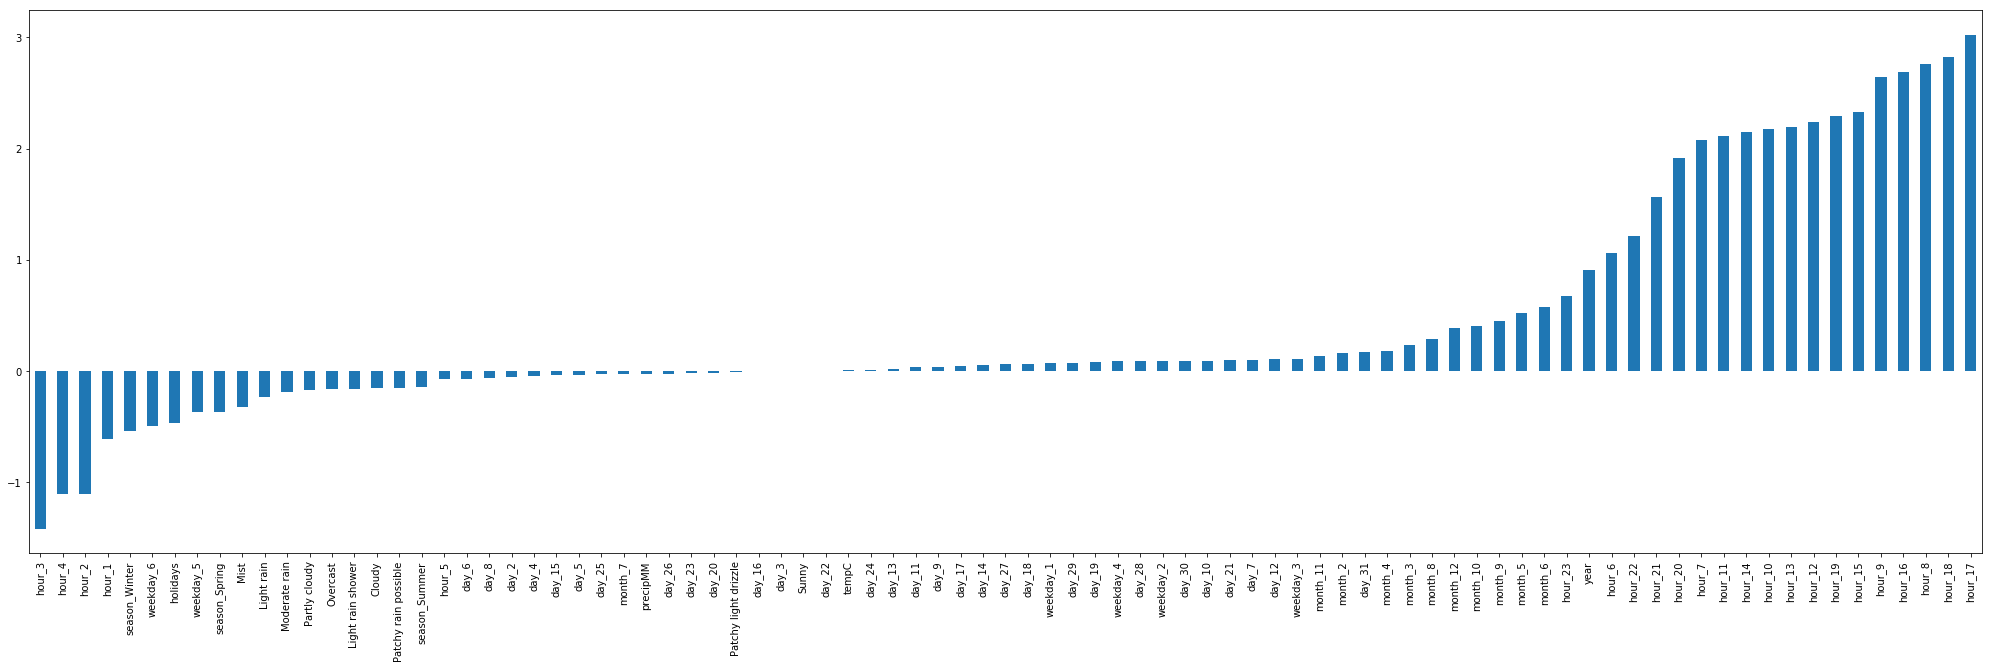

In [204]:
fig, ax = plt.subplots(figsize=(35,10))
pd.Series(data=model.coef_, index=X.columns).sort_values().plot('bar')

In [189]:
data = pd.DataFrame(model..feature_importances_,(X_train.columns)).reset_index()
data.columns = ["feature","importance"]
data = data.sort_values(by='importance')
fig, ax = plt.subplots(figsize=(20,50))
plt.barh(data["feature"], data["importance"])
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

### Decision Tree

In [134]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [135]:
model.score(X_train, y_train)

1.0

In [136]:
model.score(X_test, y_test)

0.9095291173643205

In [138]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
R2_ = r2_score(y_test, y_pred)
MSE_ = mean_squared_error(y_test, y_pred)
print(R2_, MSE_)

0.9095291173643205 0.23199895082955038


In [151]:
from sklearn.tree import DecisionTreeRegressor
print(model.get_depth())
print(model.get_n_leaves())
len(model.apply(X_train))

51
7524


8028

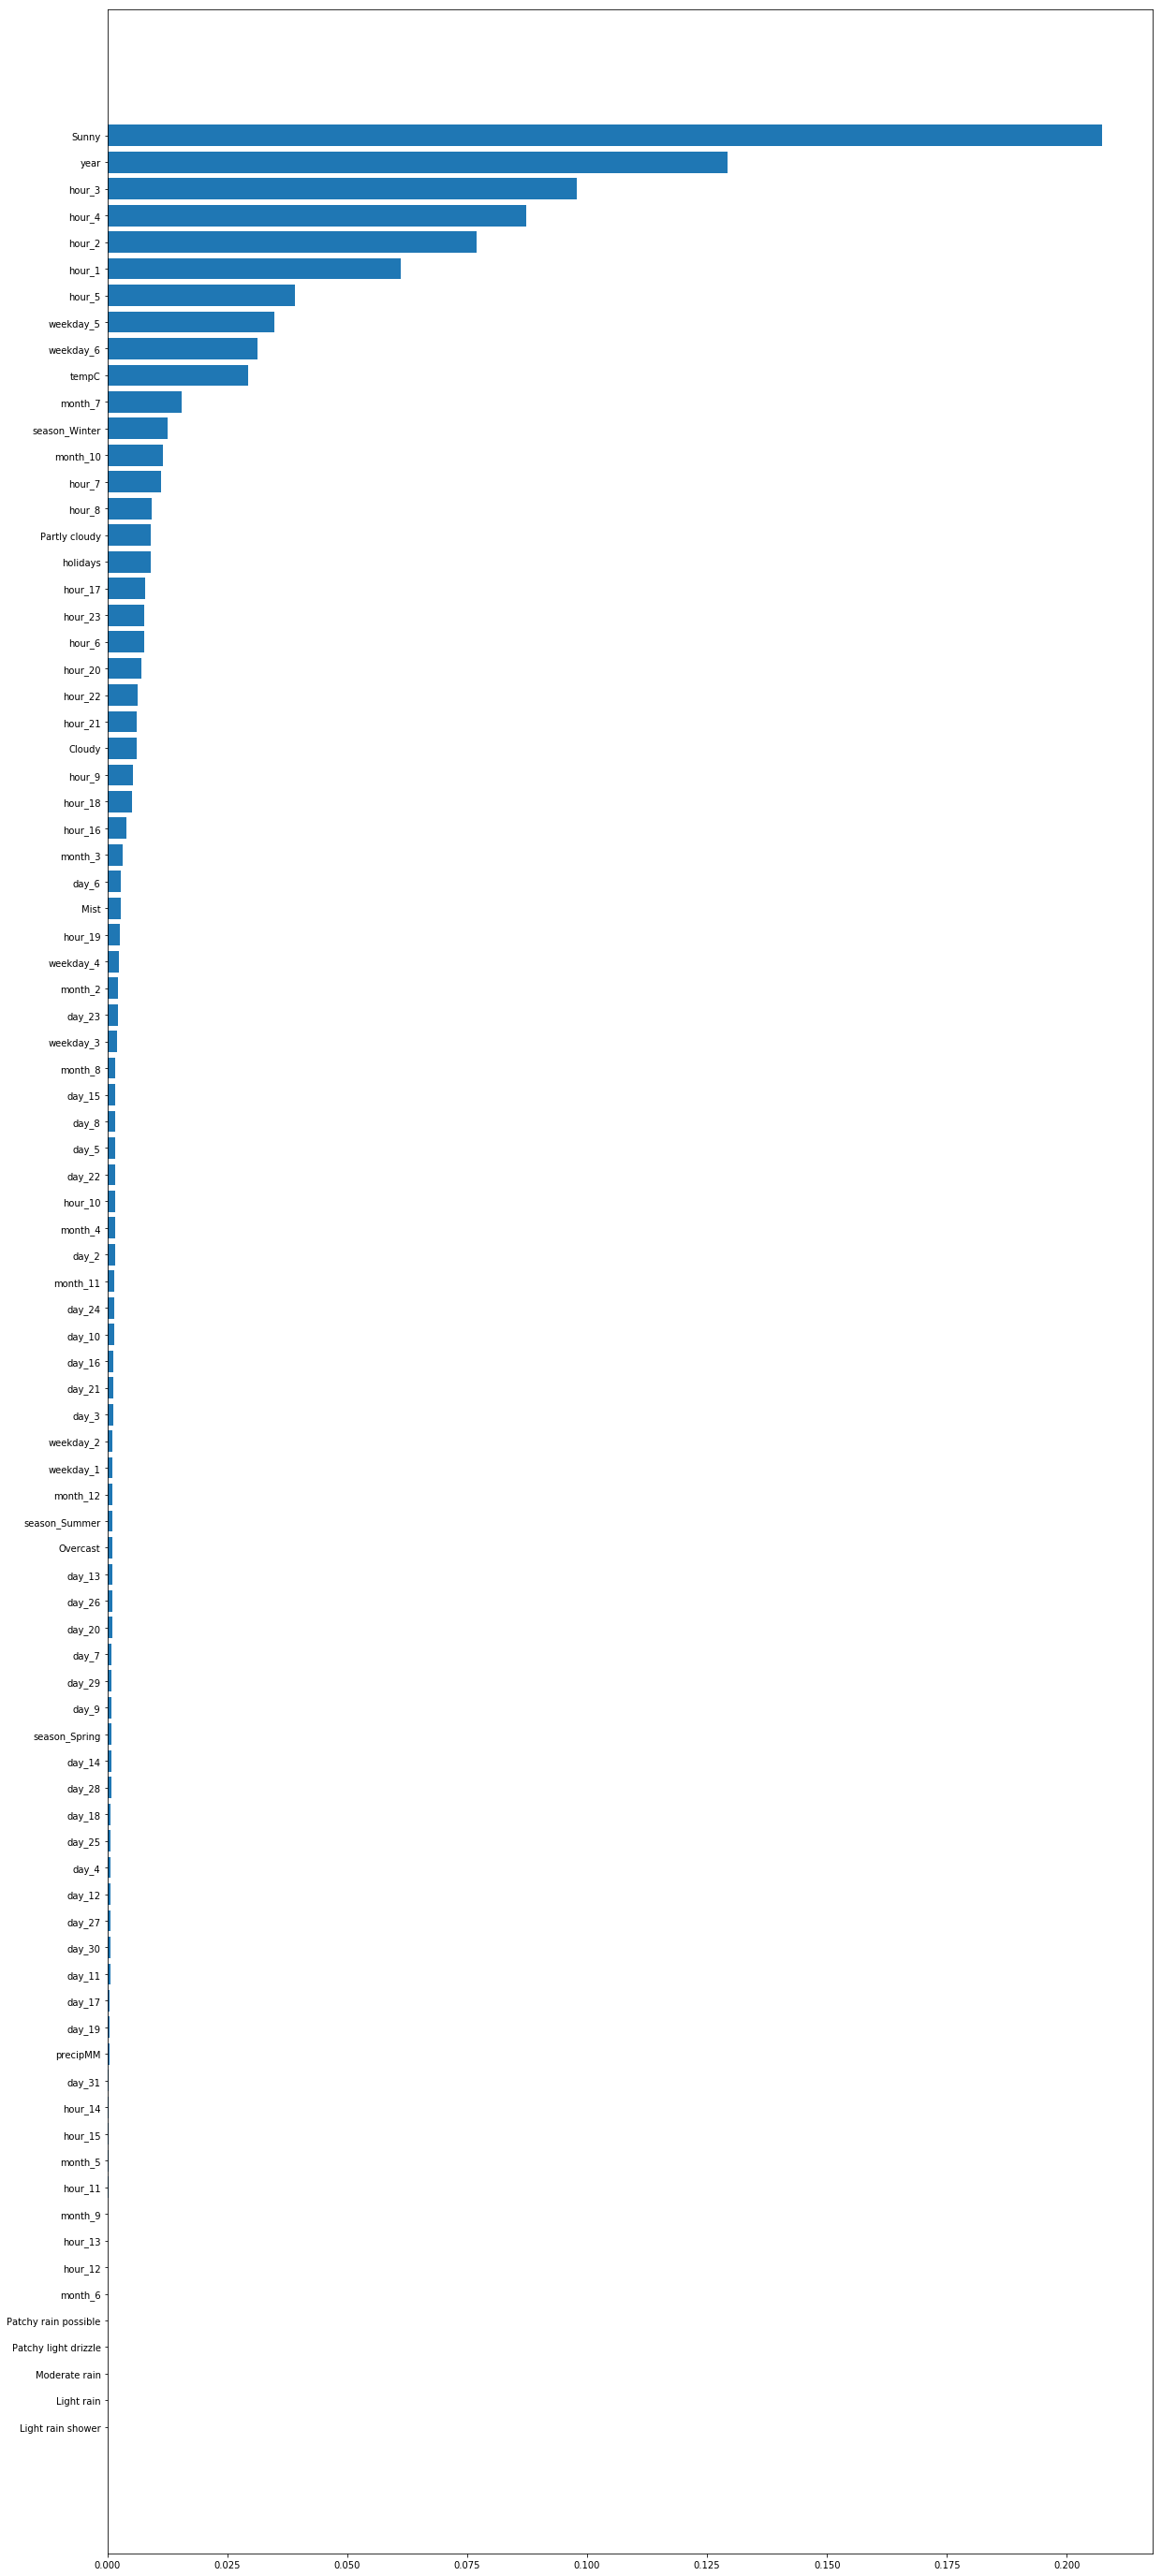

In [183]:
data = pd.DataFrame(model.feature_importances_,(X_train.columns)).reset_index()
data.columns = ["feature","importance"]
data = data.sort_values(by='importance')
fig, ax = plt.subplots(figsize=(20,50))
plt.barh(data["feature"], data["importance"])
plt.show()